In [3]:
import numpy as np
import pandas as pd
import queue
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from random import *

from scripts.NN import *
from scripts.io import *

## Part 1: Autoencoder implementation

In [4]:
# generate 8 bit binary vectors
identity = list(np.identity(8))

In [5]:
train = [[list(i),list(i)] for i in identity]
train

[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]]

In [6]:
nn = NeuralNetwork([[8,3, "sigmoid"], [3,8, "sigmoid"]])

In [7]:
losses = pd.DataFrame(columns = ['Epoch', 'Train']) 
nn.lr = 0.3
for epoch in range(5000):
    loss = nn.fit(train)
    losses = losses.append({'Epoch' : epoch, 'Train' : loss}, ignore_index=True)

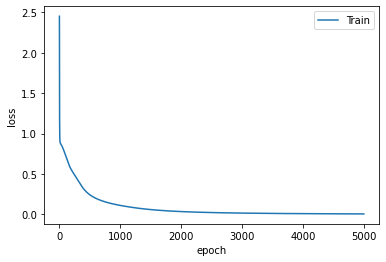

In [8]:
# Plot loss
fig,ax = plt.subplots()

for name in ['Train']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

In [9]:
# pass all 8 vectors in, showing input and the output
# sorry this is so ugly
for i in identity:
    print("input: ",list(i))
    print("output: ",nn.predict(list(i)), "\n")

input:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
output:  [0.9473754734202734, 0.015426506307545896, 1.0388721776128296e-08, 0.018275194028274093, 3.9807552675531444e-11, 0.0004149203684688306, 3.7220851998870895e-05, 2.6715919805439e-06] 

input:  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
output:  [0.018338477538297572, 0.9514033908769092, 0.011667732828716821, 1.7792710816207178e-08, 1.3074261146724578e-09, 0.010155933994663153, 5.545233727198674e-05, 1.069192116034951e-09] 

input:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
output:  [2.4116438715095064e-07, 0.02615587429951427, 0.9312219161087016, 4.288873490391441e-09, 0.03182281541963191, 0.0023173594405142264, 0.003024905288511592, 2.5733944108619653e-06] 

input:  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
output:  [0.023719360539463524, 7.671956117865111e-07, 1.2250712944896576e-09, 0.954711947664235, 2.154074897290138e-05, 3.288359932002656e-07, 0.020519056846393657, 0.011799641335101214] 

input:  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0

## Part 2: Adapt for classification, and develop training regime

### 2. a) Describe your process of encoding your training DNA sequences into input vectors in detail. Include a description of how you think the representation might affect your network’s predictions.

For positive training examples, I used all 17 bp each. For the negative examples, I took the last 17 bp of each sequence. Since the neg sequences are the 1000 bp upstream of a yeast gene, I reasoned that the last 17 bp should be closest to the TSS. My hope was that these 17 bp would fall in or around an area that a transcription factor would normally bind. I'm not sure if this logic is correct, but it was a straightforward way to subset the long sequences. I think it is important for both the positive and negative examples to be potential TF binding sites so that the network learns what distinguishes a Rap1 binding site from other binding sites, rather than what distinguishes a transcription factor binding site in general. 

For the encoding, each nucleotide in a DNA sequence is represented as a binary vector of length 4. Example: [1, 0, 0, 0], where a 1 corresponds to which nucleotide it is: [A, C, G, T]. Thus, to get the entire sequence I concatenate these vectors together, resulting in a vector of length 4 * 17. Example: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]. This one-hot encoding will place equal weight on each nucleotide, rather than place more importance on some nucleotides than others. There may be some relationship between the frequency of one type of nucleotide and Rap1 binding, but I went with one-hot encoding to be safe. 

All of the positive examples were classified as 1, and neg examples classified as 0.

In [10]:
positives, full_negs = read_train_seqs(pos_file="./data/rap1-lieb-positives.txt", neg_file="./data/yeast-upstream-1k-negative.fa")

# just take the last 17 bp of all of the negatives
negatives = [seq[len(seq)-17:len(seq)] for seq in full_negs]
negatives[1:5]

['AAATCTTCACCACCCAA',
 'AGTAAATAACAGATAAT',
 'CATTGTAAAGGAAAACC',
 'AAAATAATAGGTGTAAA']

In [11]:
pos_enc = [[encode_seq(seq),[1]] for seq in positives]


In [12]:
neg_enc = [[encode_seq(seq),[0]] for seq in negatives]

### 3. a) Describe your training regime. How was your training regime designed so as to prevent the negative training data from overwhelming the positive training data?

I first split the data into 80% training, 20% validation. I tried to ensure that the validation set had a good proportion of both positives and negatives. For each epoch, I split the training data into batches, with each batch containing a balanced number of positive and negative examples. Since there are a lot more negative examples than positives, I wanted to make sure the model saw all of the negative examples while still having class-balanced batches. Thus, I re-used some of the positive examples more than once per epoch. To do this, I used two separate queues of training data--one for positive examples and one for negative examples. To create each batch, I dispense a fixed number of positives and negatives from each queue. The epoch ends when the negative queue runs out. The positive queue is replenished with examples when needed.

I also wanted to prevent the model from seeing the same ordering of examples in batches every time. To combat this I repopulated and shuffled the queues after each epoch so that the same positive and negative examples wouldn't always be in the same batch.

In [26]:
# Put some examples in a validation set. 
# 80/20 split for positives: Since there are only 137 positives, let's save 27 positives.
# Let's just save 64 negs for validation.

pos_test_len = 27
pos_test_idx = sample(range(len(pos_enc)), pos_test_len)
neg_test_len = 64
neg_test_idx = sample(range(len(neg_enc)), neg_test_len)

pos_test = [pos_enc[idx] for idx in pos_test_idx]
neg_test = [neg_enc[idx] for idx in neg_test_idx]

pos_train = [pos_enc[idx] for idx in range(len(pos_enc)) if idx not in pos_test_idx]
neg_train = [neg_enc[idx] for idx in range(len(neg_enc)) if idx not in neg_test_idx]

validation = pos_test + neg_test
shuffle(validation)

In [27]:
nn = NeuralNetwork([[68,25, "sigmoid"], [25,1, "sigmoid"]])
losses = training(pos_batch_size = 50,neg_batch_size = 155, 
                  n_epochs = 10, nn = nn, neg_train=neg_train, pos_train = pos_train, validation=validation)

### 4. a) Provide an example of the input and output for one true positive sequence and one true negative sequence.

In [28]:
# positive sequence
print("input: ", pos_enc[0][0])
print("output: ",nn.predict(pos_enc[0][0]))

input:  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
output:  [0.9920473679123359]


In [29]:
# neg sequence
print("input: ", neg_enc[0][0])
print("output: ",nn.predict(neg_enc[0][0]))

input:  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
output:  [0.004340555056243026]


### 4. b) Describe your network architecture, and the results of your training. How did your network perform in terms of minimizing error?

I used a network with 68 input nodes, a hidden layer with 25 nodes, and 1 output node. I used all sigmoid activations. My lr was 0.05, and I trained for 10 epochs. Both the training and validation losses steadily decrease.

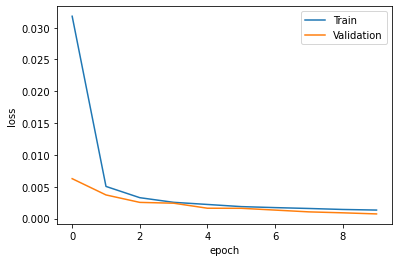

In [30]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in ['Train', 'Validation']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

### 4. c) What was your stop criterion for convergence in your learned parameters? How did you decide this?

If the validation loss goes below, 0.004, the training stops. I chose 0.004 because I ran training for a range of epochs and calculated the AUC on the validation set, and it seems to reach an AUC of 0.99 at that value. If the loss was any lower, the network is not learning much more. Also, I am realizing that I did this wrong and should have probably used a held-out test set that the model has never seen to calculate the AUC.

## Part 3: Cross-validation

### 5. a) How can you use k-fold cross validation to determine your model’s performance?

K-fold cross validation ensures that the network isn't overfitting to a particular training and validation split. It splits the training data into k folds and trains k different networks where the validation set is the k-th fold, and the training set is everything minus that k-th fold. You can then average the AUCs for each fold to determine the model's performance.

### 5. b) Given the size of your dataset, positive and negative examples, how would you select a value for k?

It seems like popular values of k are 3, 5, and 10. I chose 5 so that the network can see a variety of different splits, but also so that the positive examples aren't spread too thin across the folds.

### 5. c) Using the selected value of k, determine a relevant metric of performance for each fold. Describe how your model performed under cross validation.

In [19]:
k = 5
nn = NeuralNetwork([[68,25, "sigmoid"], [25,1, "sigmoid"]])
all_preds, all_actuals = cross_validation(k = k, nn= nn, pos_batch_size=50, neg_batch_size = 211, n_epochs = 5, pos_enc = pos_enc, neg_enc = neg_enc)

In [20]:
# Get fpr, tpr, and auc for each model
result_table = pd.DataFrame(columns=['k', 'fpr','tpr','auc'])

for i in range(k):  
    fpr, tpr, _ = roc_curve(all_actuals[i],  all_preds[i])
    auc = roc_auc_score(all_actuals[i], all_preds[i])
    
    result_table = result_table.append({'k': i,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
result_table

,k,fpr,tpr,auc
0,0,"[0.0, 0.0, 0.0, 0.0015822784810126582, 0.00158...","[0.0, 0.037037037037037035, 0.7037037037037037...",0.999531
1,1,"[0.0, 0.0, 0.0, 0.1629746835443038, 0.16772151...","[0.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0...",1.000000
2,2,"[0.0, 0.0, 0.0, 0.16455696202531644, 0.1677215...","[0.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0...",1.000000
3,3,"[0.0, 0.0, 0.0, 0.058544303797468354, 0.063291...","[0.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0...",1.000000
4,4,"[0.0, 0.0, 0.0, 0.16823899371069181, 0.1713836...","[0.0, 0.034482758620689655, 1.0, 1.0, 1.0, 1.0...",1.000000


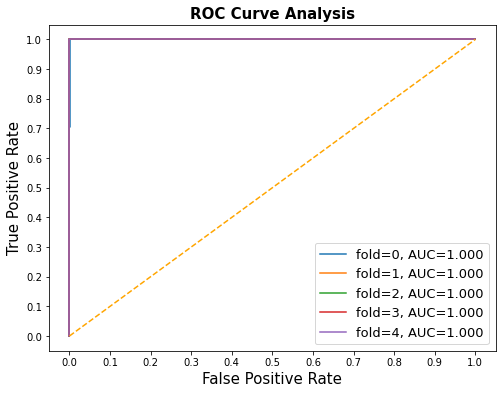

In [21]:
# ROC 
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="fold={}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Part 4: Extension

### Trying some hyperparameter optimization using grid search

In [22]:
# try a few different architectures, lrs, and change up the positive batch size per iteration
architectures = [[[68,25, "sigmoid"], [25,10, "sigmoid"], [10,1, "sigmoid"]],
                 [[68,10, "sigmoid"], [10,5, "sigmoid"], [5,1, "sigmoid"]],
                 [[68,10, "sigmoid"], [10,1, "sigmoid"]]
                ]
lrs = [0.1, 0.05, 0.01]
pos_batch_size = [30, 50, 80]


In [23]:
k = 5
result_table = pd.DataFrame(columns=['arch', 'lr','pos_batch_size','avg_auc'])

for arch in architectures:
    for lr in lrs:
        for pbs in pos_batch_size:
            print("testing arch: ", arch, ", lr: ", lr, ", pos_batch_size: ", pbs, "...")
            nn = NeuralNetwork(setup=arch, lr = lr)
            all_preds, all_actuals = cross_validation(k = k, nn=nn, pos_batch_size=pbs,neg_batch_size = 211, n_epochs = 5, pos_enc = pos_enc, neg_enc = neg_enc)
            aucs = 0
            for i in range(k):  
                auc = roc_auc_score(all_actuals[i], all_preds[i])
                aucs+=auc
            avg_auc = aucs/k
            result_table = result_table.append({'arch': arch,
                                        'lr':lr, 
                                        'pos_batch_size':pbs, 
                                        'avg_auc':avg_auc}, ignore_index=True)

testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  30 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  50 ...


/Users/mtsui1/Documents/Classes/Algs/Project3/scripts/NN.py:263: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  80 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  30 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  50 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  80 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  30 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  50 ...
testing arch:  [[68, 25, 'sigmoid'], [25, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  80 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  30 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] 

/Users/mtsui1/Documents/Classes/Algs/Project3/scripts/NN.py:263: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  80 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  30 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  50 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.05 , pos_batch_size:  80 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  30 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  50 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 5, 'sigmoid'], [5, 1, 'sigmoid']] , lr:  0.01 , pos_batch_size:  80 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  30 ...
testing arch:  [[68, 10, 'sigmoid'], [10, 1, 'sigmoid']] , lr:  0.1 , pos_batch_size:  50 ...
testing arch:  

In [24]:
result_table

,arch,lr,pos_batch_size,avg_auc
0,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.10,30,0.999871
1,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.10,50,0.997049
2,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.10,80,0.999965
3,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.05,30,0.999766
4,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.05,50,0.999789
5,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.05,80,0.999707
6,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.01,30,0.999799
7,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.01,50,0.999326
8,"[[68, 25, sigmoid], [25, 10, sigmoid], [10, 1,...",0.01,80,0.999742
9,"[[68, 10, sigmoid], [10, 5, sigmoid], [5, 1, s...",0.10,30,0.999906


In [25]:
result_table.to_csv("./hyperparameter_tuning_results.csv")

After trying a few different architectures (adding hidden layers, varying number of nodes in hidden layers), different learning rates, and different amounts of positive examples per batch, they didn't seem to have a big effect on the cross-validated AUCs. All of the average AUCs are still very high. I would say that using the architecture [[68, 10, sigmoid], [10, 5, sigmoid], [5, 1, sigmoid]] seems to decrease the AUC. Not sure why this is, but it could possibly be related to vanishing gradients? Maybe adding more layers means that it's harder for my network to propogate useful information back to the first layers. Just a hypothesis. This architecture combined with a lr of .1 and positive batch size of 50 has the lowest AUC of 0.95. The lr is probably too large and the gradient descent process might be getting stuck at a place where the loss can't decrease further. I don't really see an effect on performance with different pos_batch_size values.

## Part 5: Evaluate your network on the final set

In [31]:
# read in test set
with open("./data/rap1-lieb-test.txt") as f:
        test = f.read().splitlines()

In [32]:
test_enc = [encode_seq(seq) for seq in test]

In [33]:
# Just use model from part 2 to predict on test set, print outputs to file
with open('predictions.txt', 'w') as f:
    for t in range(len(test_enc)):
        print(test[t], "\t", nn.predict(test_enc[t])[0], file=f)